# How to use the ParlaSent model? A practical tutorial

Authors: Michal Mochtak, Peter Rupnik, Taja Kuzman, and Nikola Ljubešić

Date: 21/8/2024

## Introductory remarks ⛳

This is an interactive Jupyter notebook that presents a step-by-step tutorial on how to use the ParlaSent model with your own data. The overall structure of the notebook can organized around two elements: 1) sentence extraction and 2) sentence annotation.

If you use this tutorial, please cite the paper:


> Mochtak, Michal, Peter Rupnik, and Nikola Ljubešić. 2024. “The ParlaSent Multilingual Training Dataset for Sentiment Identification in Parliamentary Proceedings.” In Proceedings of the 2024 Joint International Conference on Computational Linguistics, Language Resources and Evaluation (LREC-COLING 2024), edited by Nicoletta Calzolari, Min-Yen Kan, Veronique Hoste, Alessandro Lenci, Sakriani Sakti, and Nianwen Xue, 16024–36. Torino, Italia: ELRA and ICCL. https://aclanthology.org/2024.lrec-main.1393.



## Prerequisities ⚡
Google Colab is an interactive developement environment with acces to computational resources that are easy to utilize free of charge (read more about it here: https://colab.research.google.com/).

In order to use the ParlaSent model, you need to first connect to an interactive environment that has access to a graphical processing unit. In order to do that, click "Runtime" in the top toolbar and select "Change runtime type":
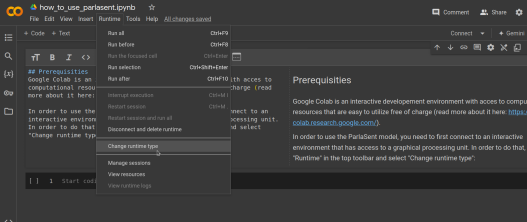
<br>
<br>
After a pop up appears, select any available GPU accelerator and save your selection:

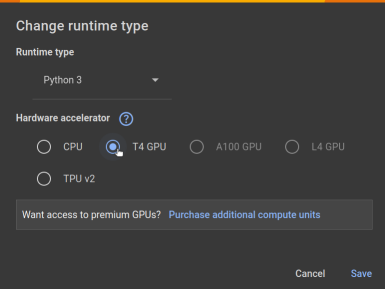

Finally, in the top right corner, click "Connect". After a while, a green tick mark (✔) will appear. Your virtual session has been succesfully set up.

## Loading data for processing 💾
This notebook is designed for a simple use case that expects users to prepare their data outside the Google Colab environment as a plain .csv file and then upload it for further processing. This paper's repository contains a sample file which you can use as guidance for formatting your own data. The file contains 124 speeches in English from the debate on the proposal for a regulation of the European Parliament and of the Council setting emission performance standards for new passenger cars and new light commercial vehicles held on 3rd March 2018. The file contains just two columns - "doc_id" as a document identifier and "speech" for the actual transcripts (the pipeline does not require anything else).

In order to use the file (or any other file you prepare), upload the file to your interactive session by clicking the folder icon on the left and "drag-and-drop" your file to the area under the folder "sample_data." The file will be uploaded to your interactive session and will be available for you to process. It is important to realize the file exists only in this interactive session and will be deleted when you close it. That applies also to any file you create in your session (e.g., the processed data).

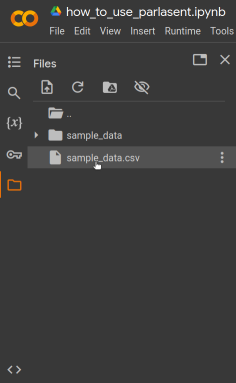



## Processing the data 🎆

The processing pipeline can be divided into two steps: 1) sentence extraction and 2) sentence annotation. From now on, the notebook will also use code cells, which can be executed by clicking the small "play" icon next to them (hover over the cell to make it visible). The only cell you need to alter (if needed) is the one below with a few meta-parameters that will be used in the pipeline.

In [9]:
# Before we start, we will set a few meta parameters for the pipeline to use.
language = "english" # This parameter indicates what language your input text is so trankit can load a proper sentence parser for you. In this example, the speeches are in English; check the available languages at https://trankit.readthedocs.io/en/latest/pkgnames.html (look for the Code Name for pipeline initialization).
text_column = "speech" # Name of a column in the .csv file with the input we want to analyze. In this example, the column we will process is "speech".
doc_id = "doc_id"    # Name of a column with a unique indetifier of a text to process. In this example the column is "doc_id".
filename = "sample_data.csv" # Name of the file you uploaded to Google Colab and want to process.

### Loading the necessary packages 💻
To process the input data, we need to install and load a few packages we will use.

In [ ]:
# Install missing packages to your session; this needs to be done every time you
# open the notebook as the session is interactive.
!pip install simpletransformers
!pip install trankit

In [ ]:
# Load the necessary packages.
import simpletransformers.classification as cl
import trankit
import pandas as pd

### Step 1: Sentence extraction ⛏
Now that we have all the necessary packages loaded and ready to use, we can proceed with the first step—sentence extraction.

In [33]:
# Load the dataset you want to process; this tutorial works with a plain .csv
# file for simplicity.
df = pd.read_csv(filename)

In [ ]:
# Load the trankit pipeline with the language model you specified earlier.
p = trankit.Pipeline(lang='english', embedding='xlm-roberta-base', gpu=True, cache_dir='./cache')

In [ ]:
# Check the dataset to be sure it was read correctly
df

In [23]:
# Split texts into sentences. We use a simple loop as the model processes inputs sequentially.
sentences = []
for n in range(0, len(df[text_column])):
  one_text = pd.DataFrame.from_dict(p.ssplit(df[text_column][n]))
  one_text["doc_id"] = df[doc_id][n]
  one_text = one_text.drop(["text", "lang"], axis = 1)
  sentences.append((one_text))

# Concatenate the list and reset the index.
sentences = pd.concat(sentences)
sentences.reset_index(drop=True, inplace=True)

# Extract data from JSON format and patch everything together.
sentences_final = pd.concat([sentences.drop(['sentences'], axis=1), pd.json_normalize(sentences['sentences'])], axis=1)

# Rename the 'text' column to 'sentence'.
sentences_final.rename(columns={'text': 'sentence'}, inplace=True)

In [ ]:
# Check the result of sentence extraction. It is a data frame with
# doc_id column referring to the original document, id column referring to a sentence id within
# the processed input (e.g. speech), sentence column contains the extracted grammatical units
# (i.e., the sentences), and dspan column contains indexes for the beginning and end of
# each sentence in the processed string.
sentences_final

### Step 2: Sentiment annotation 🌡
With the extracted sentences, we can continue with the second step - sentiment annotation.

In [ ]:
# Load the ParlaSent model from the Huggingface Hub.
model = cl.ClassificationModel("xlmroberta", "classla/xlm-r-parlasent")

In [ ]:
# Annotate the prepared sentences with the ParlaSent model.
prediction = model.predict(to_predict = sentences_final["sentence"].tolist())

final_df = sentences_final.assign(predict = prediction[1])

In [ ]:
# Check the result. The final_df data frame now cotains an additional column
# "predict" with the predictions the model made. As the classification model
# predicts the label (score) on a continuous scale, similar to a regression model,
# it can produce scores above and bellow the scale we used for training (0-5).
# It is worth mentioning that 124 speeches containing 1289 sentences took
# approximately 6 seconds to annotate (T4 GPU).
final_df

In [32]:
# Save the annotated data as a .csv file. The new file is located in the same
# location as the input file you uploaded at the beginning. If it does not
# appear there automatically, click the refresh button (look for the circled
# arrow) to reload the content of the folder. To download the file, right-click
# on it and choose "Download" to save it on your local machine.
final_df.to_csv('output.csv', index=False)

## Closing remarks 👋
The tutorial has walked you through the whole annotation pipeline. We have demonstrated how easy it is to set it up and execute it on your own data. With just a few meta-parameters you need to define in reference to your uploaded document (column names and the language you want to analyze), you can easily annotate your own text data in no time. It does not matter whether it is in English, German, Czech, Polish, or Italian. The model will do the job. The result is a simple data frame with annotated sentences that can be further processed/aggregated for specific research purposes (e.g., level of speeches, time period, or groups) and merged with the available metadata (using the doc_id identifier).